In [38]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

try:
    os.chdir(r"/Users/eylul/desktop/archive")
    print("Yeni Dizin:", os.getcwd())

except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")

Yeni Dizin: /Users/eylul/Desktop/archive


In [4]:
import os
import shutil

src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"


os.makedirs(dst_dir, exist_ok=True)


for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

print(f"Tüm görüntüler '{dst_dir}' klasöründe toplandı. Toplam: {len(os.listdir(dst_dir))} dosya")

Tüm görüntüler 'all_images' klasöründe toplandı. Toplam: 10015 dosya


In [5]:
import csv
import os

# Tam yol verildi
metadata_file = "/Users/eylul/Desktop/HAM10000_metadata.csv"
metadata = []

# Dosya var mı kontrol et
if not os.path.exists(metadata_file):
    raise FileNotFoundError(f"{metadata_file} bulunamadı! Lütfen yolunu kontrol et.")

# CSV'yi oku
with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

print(f"Metadata yüklendi. Toplam satır: {len(metadata)}")

Metadata yüklendi. Toplam satır: 10015


In [6]:
label_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

data_list = []

for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")
    if os.path.exists(img_path):
        data_list.append((img_path, label))

print(f"Toplam kullanılabilir veri: {len(data_list)}")

Toplam kullanılabilir veri: 10015


In [16]:
import random


class_groups = {i: [] for i in range(7)}
for path, label in data_list:
    class_groups[label].append((path, label))

train_list, val_list, test_list = [], [], []

for label, items in class_groups.items():
    random.shuffle(items)
    n = len(items)
    test_n = int(n * 0.15)
    val_n = int(n * 0.15)
    test_list.extend(items[:test_n])
    val_list.extend(items[test_n:test_n+val_n])
    train_list.extend(items[test_n+val_n:])


random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

Train: 7017, Val: 1499, Test: 1499


In [24]:
from torchvision import transforms

IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

data_dir = "/Users/eylul/Desktop/archive/splitted"
batch_size = 32
num_epochs = 10
learning_rate = 0.001
num_classes = 7

print("Veri yolu:", data_dir)
print("Batch size:", batch_size)
print("Epoch sayısı:", num_epochs)
print("Learning rate:", learning_rate)
print("Sınıf sayısı:", num_classes)

Veri yolu: /Users/eylul/Desktop/archive/splitted
Batch size: 32
Epoch sayısı: 10
Learning rate: 0.001
Sınıf sayısı: 7


In [33]:
from torch.utils.data import Dataset

class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        from PIL import Image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [37]:
import csv
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 🔹 1️⃣ Dosya ve resim klasörü yolları
csv_file = "/Users/eylul/Desktop/HAM10000_metadata.csv"  # CSV dosyası
image_dir = "/Users/eylul/Desktop/HAM10000_images/"      # Resimlerin bulunduğu klasör

# 🔹 2️⃣ CSV’den veriyi oku ve tam resim yolunu oluştur
data_list = []
with open(csv_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # CSV’deki image_id sütunu
        image_filename = row['image_id'] + ".jpg"  # Resim dosyası JPEG ise
        image_path = os.path.join(image_dir, image_filename)
        label = row['dx']  # Etiket sütunu
        data_list.append({
            'image_path': image_path,
            'label': label
        })

print("Toplam veri:", len(data_list))

# 🔹 3️⃣ Train / Validation / Test olarak böl
train_list, temp_list = train_test_split(data_list, test_size=0.3, random_state=42, stratify=[d['label'] for d in data_list])
val_list, test_list = train_test_split(temp_list, test_size=0.5, random_state=42, stratify=[d['label'] for d in temp_list])

print("Train:", len(train_list), "Val:", len(val_list), "Test:", len(test_list))

# 🔹 4️⃣ Dataset sınıfı
class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        image = Image.open(item['image_path']).convert("RGB")
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# 🔹 5️⃣ Görüntü transformları
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# 🔹 6️⃣ Dataset ve DataLoader
train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader hazır!")

Toplam veri: 10015
Train: 7010 Val: 1502 Test: 1503
✅ DataLoader hazır!


In [14]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transform)

dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Toplam görsel sayısı:", dataset_size)
print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))
print("Sınıf sayısı:", len(full_dataset.classes))
print("Sınıf isimleri:", full_dataset.classes)

for cls_idx, cls_name in enumerate(full_dataset.classes):
    count = sum([1 for _, label in full_dataset.samples if label == cls_idx])
    print(f"{cls_name}: {count} görsel")

Toplam görsel sayısı: 10015
Train: 7010 Val: 1502 Test: 1503
Sınıf sayısı: 7
Sınıf isimleri: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
akiec: 327 görsel
bcc: 514 görsel
bkl: 1099 görsel
df: 115 görsel
mel: 1113 görsel
nv: 6705 görsel
vasc: 142 görsel


In [15]:
import torch.nn.functional as F

class DropBlock2D(nn.Module):
    def __init__(self, block_size, drop_prob):
        super(DropBlock2D, self).__init__()
        self.block_size = block_size
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        gamma = self.drop_prob / (self.block_size ** 2)
        for _ in range(x.size(0)):
            mask = (torch.rand(x.size(2), x.size(3), device=x.device) < gamma).float()
            mask = F.pad(mask, [self.block_size//2]*4)
            mask = 1 - F.max_pool2d(mask.unsqueeze(0), self.block_size, stride=1, padding=0)
            x[_] = x[_] * mask
        return x

class CNN_DropBlock(nn.Module):
    def __init__(self, num_classes, drop_prob=0.3, block_size=3):
        super(CNN_DropBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.dropblock = DropBlock2D(block_size=block_size, drop_prob=drop_prob)
        self.classifier = nn.Sequential(
            nn.Linear(128*28*28, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.dropblock(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN_DropBlock(num_classes=7)
print(model)

CNN_DropBlock(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropblock): DropBlock2D()
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_fea

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Cihaz:", device)

Cihaz: cpu


In [17]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/10] Train Loss: 1.7482, Train Acc: 0.6499, Val Loss: 0.9608, Val Acc: 0.6844
Epoch [2/10] Train Loss: 0.8241, Train Acc: 0.7054, Val Loss: 0.9462, Val Acc: 0.6884
Epoch [3/10] Train Loss: 0.7607, Train Acc: 0.7225, Val Loss: 0.8649, Val Acc: 0.6957
Epoch [4/10] Train Loss: 0.7522, Train Acc: 0.7238, Val Loss: 0.8080, Val Acc: 0.7091
Epoch [5/10] Train Loss: 0.7095, Train Acc: 0.7412, Val Loss: 0.7889, Val Acc: 0.7264
Epoch [6/10] Train Loss: 0.6724, Train Acc: 0.7542, Val Loss: 0.8945, Val Acc: 0.7124
Epoch [7/10] Train Loss: 0.6564, Train Acc: 0.7655, Val Loss: 0.9078, Val Acc: 0.7044
Epoch [8/10] Train Loss: 0.6166, Train Acc: 0.7723, Val Loss: 0.9170, Val Acc: 0.7017
Epoch [9/10] Train Loss: 0.5787, Train Acc: 0.7894, Val Loss: 0.8576, Val Acc: 0.7197
Epoch [10/10] Train Loss: 0.5482, Train Acc: 0.8021, Val Loss: 0.9060, Val Acc: 0.7157


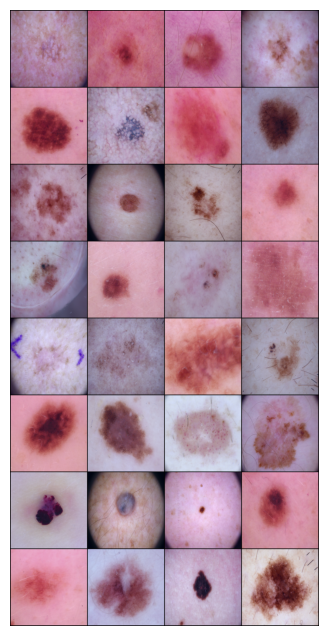

Tahminler: [2 5 5 5 5 2 5 5 5 5 5 5 5 5 1 5 0 2 5 5 5 5 0 4 6 4 5 5 5 5 5 5]
Gerçekler : [2 5 5 4 5 2 5 5 5 5 5 5 4 5 1 2 0 2 4 5 5 5 0 4 6 4 5 5 5 5 5 5]


In [18]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

model.eval()  # DropBlock devre dışı, sadece forward
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Görselleri göster
img_grid = make_grid(images, nrow=4, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')
plt.show()

print("Tahminler:", predicted.cpu().numpy())
print("Gerçekler :", labels.cpu().numpy())

In [19]:
from sklearn.metrics import f1_score

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='macro')
print("F1 Score (macro):", f1)
from sklearn.metrics import f1_score

# Sadece ilk batch ile hızlı test
data_iter = iter(test_loader)
images, labels = next(data_iter)

model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)
    
    # Accuracy
    acc = (predicted == labels.to(device)).sum().item() / labels.size(0)
    
    # F1 Score
    f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')

print("Mini Batch Test Accuracy:", acc)
print("Mini Batch F1 Score:", f1)

F1 Score (macro): 0.44597915622967754
Mini Batch Test Accuracy: 0.65625
Mini Batch F1 Score: 0.5263532763532763
